In [10]:
# add all needed imports for the project in this section

import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as PCA2D
from sklearn.model_selection import train_test_split



In [11]:
# this section loads the images from the yale dataset folder

def load_images_from_folder(folder, size=(100,100)):
    X = []
    y = []

    for label, person in enumerate(sorted(os.listdir(folder))):
        person_dir = os.path.join(folder, person)
        if not os.path.isdir(person_dir):
            continue
        
        for f in os.listdir(person_dir):
            if f.lower().endswith((".pgm", ".jpg", ".jpeg", ".png")):
                
                img = cv2.imread(os.path.join(person_dir, f), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, size)
                
                # Normalize pixel values
                img = img.astype("float32") / 255.0
                
                # Flatten for PCA
                X.append(img.flatten())
                y.append(label)
                
    return np.array(X), np.array(y)

X_faces, y_faces = load_images_from_folder("/Users/ainee_f/Documents/school_docs/computer_vision/homework05/cropped")
print(X_faces.shape, y_faces.shape)

(16380, 10000) (16380,)


In [12]:
# PCA SECTION

# NOTE: Robust PCA & LDA, and ADAPTIVE THRESHOLD


# in this section, we set-up principal component analysis to get the covariance matrix
# from this matrix, eigenvectors are found and componnets that contribute the most variance 
# are selected as "principal components"

pca = PCA(n_components=100, whiten=True) # here we select the top 100 eigenfaces (reducing dimensionality)
# NOTE: we can also try to sweet through diff values (50, 100, 150, 200, etc) and check whether we lose info, or have too much noise

# in the next step, we fit the model from the top 100 eigen values and eigenvectors and store them as pca components. we then
# subtract the mean from each face, and what we have left is 100-dimension vector
X_pca = pca.fit_transform(X_faces)

# this section visualizes the eigenfaces for us to see (we should only see a "pattern" of what a face "is")
eigenfaces = pca.components_.reshape((100,100,100))

In [13]:
# training

# in this section, we're using a KNN classifier to train the the model. We will fit our X_pca to the y_faces label
# KNN is a non-parametric classifier that computes distances from PCA space and predicts whether it is
# a face or not
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_pca, y_faces)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


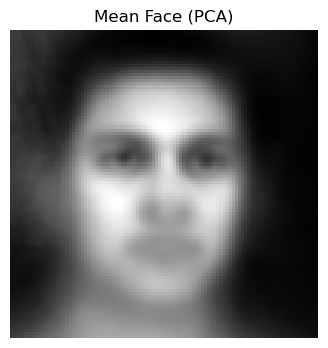

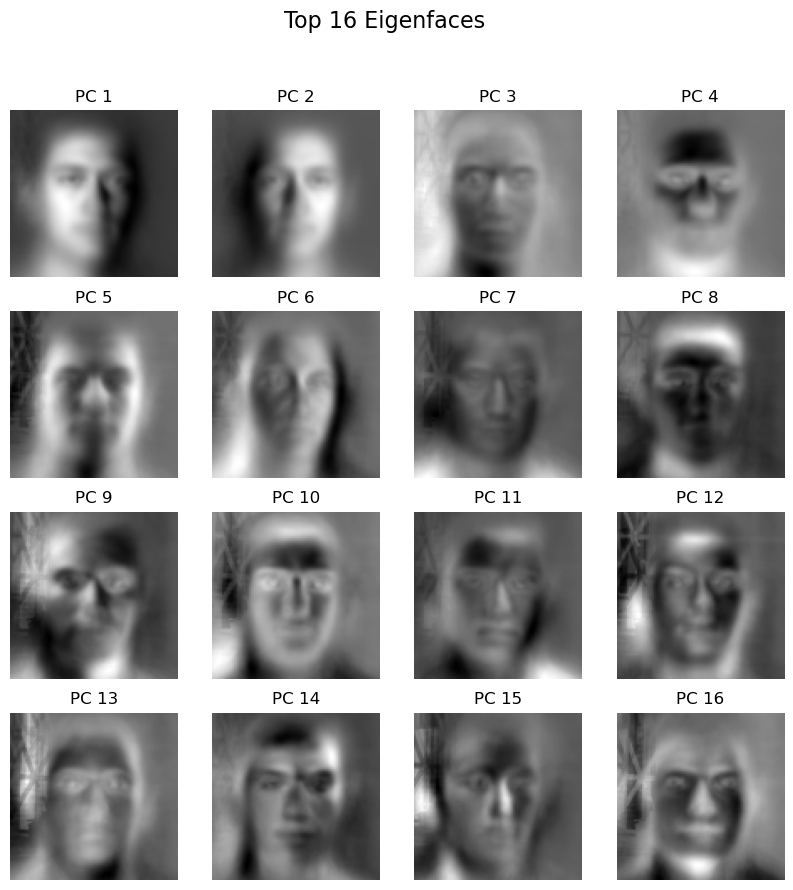

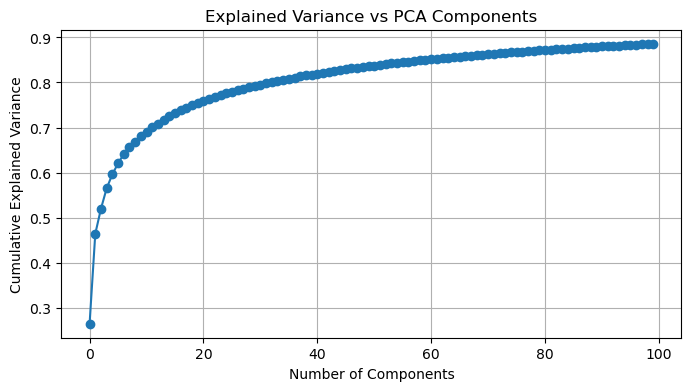

In [14]:
# TRAIN / TEST SPLIT

# here the data is split into train / test samples
# we use the typical 80/20 split

X_train, X_test, y_train, y_test = train_test_split(
    X_faces, y_faces, test_size=0.2, random_state=42 # random_state=42 indicates that the split is reproducable
)

# here we fit the top 100 principal components onto the train / test split
# whiten means each principal component is normalized
pca = PCA(n_components=100, whiten=True).fit(X_train)

# here we transform each image to a 100-dimensional vector (we reduce it)
X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

# here is where the KNN classifier is trained. it has memorized all the training set's face vectors
clf = KNeighborsClassifier(n_neighbors=1).fit(X_train_pca, y_train)

# here it will attempt to predict the classification for the test set
y_pred = clf.predict(X_test_pca)


# VISUALIZATION

# show "mean face"
mean_face = pca.mean_.reshape(100,100)

plt.figure(figsize=(4,4))
plt.imshow(mean_face, cmap='gray')
plt.title("Mean Face (PCA)")
plt.axis('off')

# Visualize first 16 eigenfaces

eigenfaces = pca.components_.reshape((pca.n_components_, 100, 100))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"PC {i+1}")
    plt.axis('off')

plt.suptitle("Top 16 Eigenfaces", fontsize=16)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs PCA Components")
plt.grid(True)
plt.show()



In [15]:
# load CIFAR10 data for comparison
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    data = batch['data']
    labels = batch['labels']
    
    # Convert to (N, 32, 32, 3)
    data = data.reshape(-1, 3, 32, 32)
    data = np.transpose(data, (0, 2, 3, 1))  # CHW -> HWC
    return data, np.array(labels)


Correct threshold: 8.785051


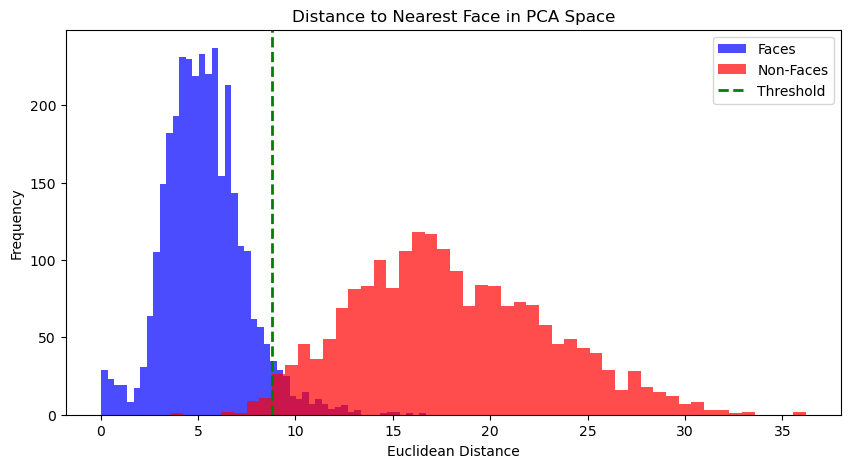

In [16]:
# load in CIFAR10 non-face data

X_cifar, y_cifar = load_cifar_batch("cifar-10-batches-py/test_batch")

# in this section i pre-process the non-face data by turning it grayscale
# and resizing it to 100x100 and normalizing 
def preprocess_nonfaces(X, size=(100,100)):
    processed = []
    for img in X[:2000]:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, size)
        img = img.astype("float32") / 255.0  
        processed.append(img.flatten())
    return np.array(processed)

X_nonfaces = preprocess_nonfaces(X_cifar)

# project CIFAR images into PCA space
X_nonfaces_pca = pca.transform(X_nonfaces)


# in this section we run the classifier. It will project the current image onto PCA space and
# try to match it to the closest training face. If it's "nearby" or the distance is small (depending on threshold)
# it will be treated as a face, if not it will be a "non-face"
def predict_face_or_not(clf, X_test_pca, threshold):
    y_pred = []
    for x in X_test_pca:
        dist, idx = clf.kneighbors([x], n_neighbors=1, return_distance=True)
        if dist[0][0] < threshold:
            y_pred.append(1)  # face
        else:
            y_pred.append(0)  # not a face
    return np.array(y_pred)


# Compute full pairwise distance matrix
D = euclidean_distances(X_train_pca)

# Replace diagonal (self-distances = 0) with +inf
# and IGNORE self distances (finding OTHER nearest training face)
np.fill_diagonal(D, np.inf)
nearest_other = np.min(D, axis=1)

# Use percentile for threshold
threshold = np.percentile(nearest_other, 95)

print("Correct threshold:", threshold)

# here we build the class labels and predictions

# create predictaed labels for the yale test faces & CIFAR data
# 1 = face, 0 = nonface
y_true = np.concatenate([
    np.ones(len(X_test_pca)),          # all Yale test images = face
    np.zeros(len(X_nonfaces_pca))      # all CIFAR images = non-face
])

y_pred = np.concatenate([
    predict_face_or_not(clf, X_test_pca, threshold),
    predict_face_or_not(clf, X_nonfaces_pca, threshold)
])

# compute distances for faces
# here it will iterate through each test face (already in PCA space) and compute
# its euclidean distance in PCA from the nearest training face and stores it
face_dists = []
for x in X_test_pca:
    dist, _ = clf.kneighbors([x], n_neighbors=1, return_distance=True)
    face_dists.append(dist[0][0])

# compute distances for CIFAR (non-faces)
# here it will do the same but for the CIFAR dataset
nonface_dists = []
for x in X_nonfaces_pca:
    dist, _ = clf.kneighbors([x], n_neighbors=1, return_distance=True)
    nonface_dists.append(dist[0][0])

# NOTE: we expect the test faces to have small distances and the CIFAR images to be far
# as shown in the overlaid histograms below

plt.figure(figsize=(10,5))
plt.hist(face_dists, bins=50, alpha=0.7, label="Faces", color='blue')
plt.hist(nonface_dists, bins=50, alpha=0.7, label="Non-Faces", color='red')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.title("Distance to Nearest Face in PCA Space")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.show()

Precision: 0.9926634768740031
Recall:    0.9499389499389499
F1-score:  0.970831383559507


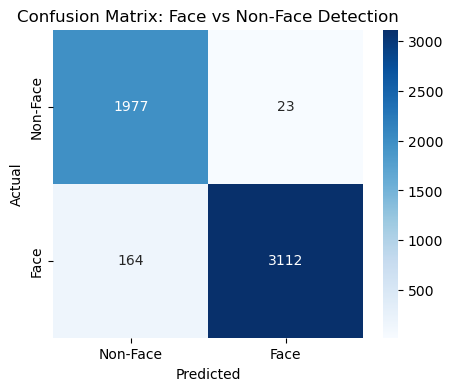

In [17]:
# metrics / scoring

precision = precision_score(y_true, y_pred) # this tells us how much was correctly identified as a face
recall    = recall_score(y_true, y_pred)    # this tells us how much of the ACTUAL faces we were able to identify
f1        = f1_score(y_true, y_pred)        # balanced measure of precision & recall (harmonic mean)

print("Precision:", precision)
print("Recall:   ", recall)
print("F1-score: ", f1)


# visualization

# this shows us a graph of correct/incorrect classifications
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Face", "Face"],
            yticklabels=["Non-Face", "Face"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Face vs Non-Face Detection")
plt.show()

